# Introduction

### The primary purpose of this notebook is to analyse the ratings of professors in Computer Science dept. of  Arizona State University at ratemyprofessor.com and see if there are any pattern/behaviour among highly rated professors that makes them so popular among students. 

### For this analysis I have scrapped all the information from ratemyprofessor.com, the code for which can be found at - [Scrape_rate_myprofessor](https://github.com/monkeydunkey/Scrape_Rate_My_professor/blob/master/dataScrubber.py). If you want to perform the same analysis for some other University or department, just update the parameters in [Scrape_rate_myprofessor](https://github.com/monkeydunkey/Scrape_Rate_My_professor/blob/master/dataScrubber.py) and you will get the information for your university and department

In [1]:
# Importing all the libraries required fro the analysis
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer

In [2]:
professors = pd.read_csv('professors.csv')
ratings = pd.read_csv('ratings.csv')

In [3]:
professors.head()

,schoolid_s,total_number_of_ratings_i,pk_id,averageratingscore_rf,teacherfirstname_t,teacherlastname_t
0,45,127,11705,3.99,Faye,Navabi
1,45,121,18588,2.40,Yinong,Chen
2,45,94,387339,4.21,Mutsumi,Nakamura
3,45,92,1011373,3.74,Janaka,Balasooriya
4,45,86,238319,2.30,Charles,Colbourn


Even though we have information on professor we will do the analysis on the ratings information only

In [4]:
ratings.head()

,rErrorMsg,rWouldTakeAgain,rClass,rTextBookUse,easyColor,teacherGrade,rEasy,rClarity,usefulGrouping,rInterest,...,onlineClass,notHelpCount,rHelpful,teacher,helpColor,rEasyString,unUsefulGrouping,rOverall,helpCount,clarityColor
0,NaN,Yes,CSE205,No,average,A,2,5,people,NaN,...,NaN,0,5,NaN,good,2.0,people,5.0,0,good
1,NaN,NaN,CSE110,Yes,average,B,3,3,people,NaN,...,NaN,1,4,NaN,average,3.0,person,3.5,0,average
2,NaN,NaN,CSE110,Yes,average,A,2,4,person,NaN,...,NaN,2,4,NaN,good,2.0,people,4.0,1,good
3,NaN,NaN,CSE205,No,average,B,3,5,person,NaN,...,NaN,1,4,NaN,good,3.0,person,4.5,1,good
4,NaN,NaN,CSE110,Yes,poor,A,1,5,person,NaN,...,NaN,1,4,NaN,good,1.0,person,4.5,1,good


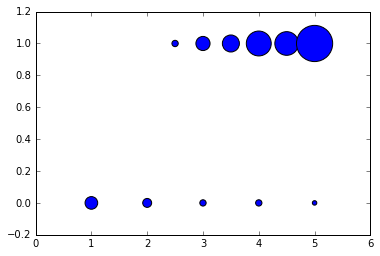

In [5]:
ratings['rWouldTakeAgainB'] = ratings['rWouldTakeAgain'].map({'Yes':1, 'No':0})
tempDf = ratings[['rWouldTakeAgainB', 'rOverall']].copy().dropna()
tempDf = tempDf.groupby( [ 'rOverall', 'rWouldTakeAgainB'] ).size().to_frame(name = 'count').reset_index()
plt.scatter(tempDf['rOverall'], tempDf['rWouldTakeAgainB'], s=tempDf['count']*10)

In [6]:
tempDf

,rOverall,rWouldTakeAgainB,count
0,1.0,0.0,16
1,2.0,0.0,8
2,2.5,1.0,4
3,3.0,0.0,4
4,3.0,1.0,20
5,3.5,1.0,29
6,4.0,0.0,4
7,4.0,1.0,62
8,4.5,1.0,56
9,5.0,0.0,2


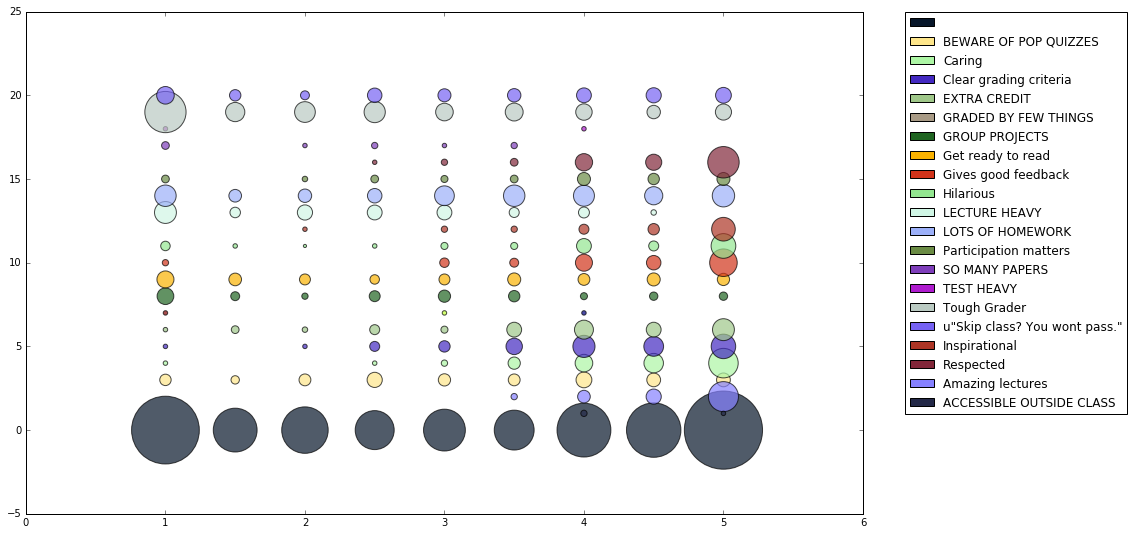

In [7]:
tags = ratings['teacherRatingTags'].copy().str.replace('[','').str.replace(']','').str.replace("u'",'').str.strip()\
.str.replace("'",'').str.split(',').apply(pd.Series, 1).stack()
tags.index = tags.index.droplevel(-1)
tags.name = 'Tags'
tempDf = ratings.join(tags)[['Tags', 'rOverall']]
tempDf['Tags'] = tempDf['Tags'].str.strip()
tempDf = tempDf.groupby( [ 'rOverall', 'Tags'] ).size().to_frame(name = 'count').reset_index()
tempDf['Numerical Tags'] = pd.Series(np.unique(tempDf['Tags'], return_inverse = True)[1])

fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 15
fig_size[1] = 9
plt.rcParams["figure.figsize"] = fig_size
fig, ax = plt.subplots()
recs = []
classes = []
for i in tempDf['Numerical Tags'].unique():
    color = np.random.rand(3,1)
    ax.scatter(tempDf[tempDf['Numerical Tags'] == i]['rOverall'], tempDf[tempDf['Numerical Tags'] == i]['Numerical Tags'], \
               s=tempDf[tempDf['Numerical Tags'] == i]['count']*10, c=color, alpha=0.7)
    recs.append(mpatches.Rectangle((0,0),1,1,fc=color))
    classes.append(tempDf[tempDf['Numerical Tags'] == i]['Tags'].unique()[0])
ax.legend(recs, classes, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

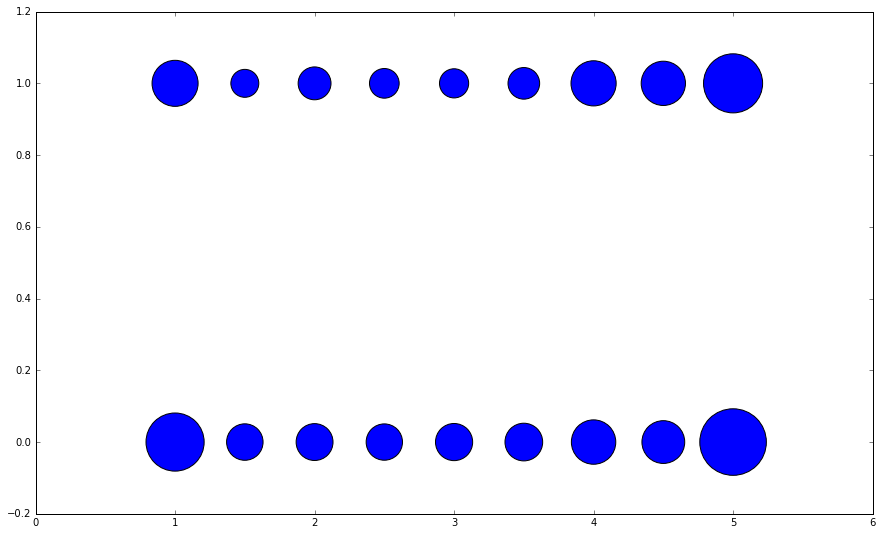

In [8]:
tempDf = ratings[['rOverall']].copy()
tempDf['rTextBookUseB'] = ratings['rTextBookUse'].map({'Yes':1, 'No':0})
tempDf = tempDf.dropna()
tempDf = tempDf.groupby( [ 'rOverall', 'rTextBookUseB'] ).size().to_frame(name = 'count').reset_index()
plt.scatter(tempDf['rOverall'], tempDf['rTextBookUseB'], s=tempDf['count']*10)

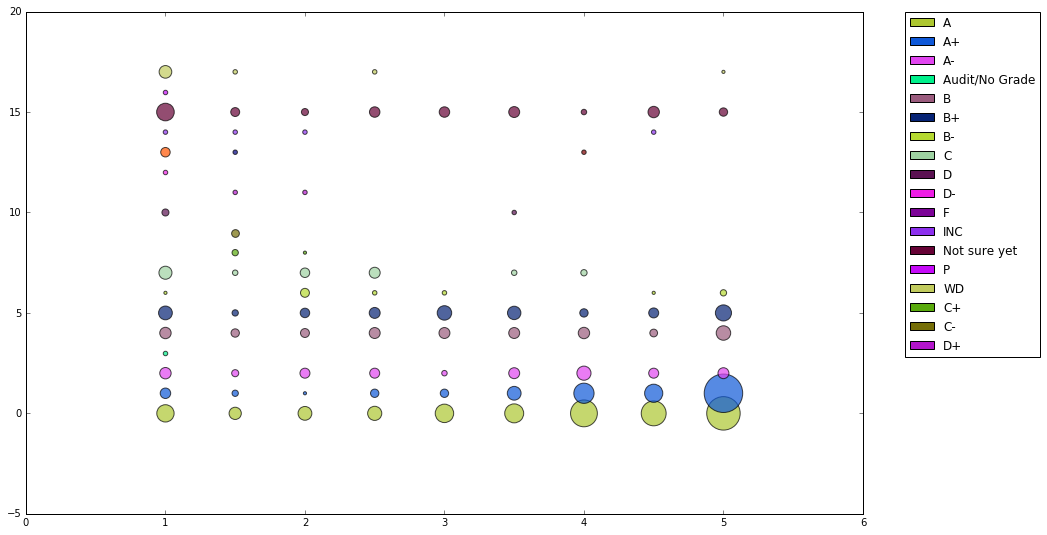

In [9]:
tempDf = ratings[['rOverall','teacherGrade']].copy().dropna()
tempDf = tempDf.groupby( [ 'rOverall', 'teacherGrade'] ).size().to_frame(name = 'count').reset_index()
tempDf['Numerical Grades'] = pd.Series(np.unique(tempDf['teacherGrade'], return_inverse = True)[1])

fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 15
fig_size[1] = 9
plt.rcParams["figure.figsize"] = fig_size
fig, ax = plt.subplots()
recs = []
classes = []
for i in tempDf['Numerical Grades'].unique():
    color = np.random.rand(3,1)
    ax.scatter(tempDf[tempDf['Numerical Grades'] == i]['rOverall'], tempDf[tempDf['Numerical Grades'] == i]['Numerical Grades'], \
               s=tempDf[tempDf['Numerical Grades'] == i]['count']*10, c=color, alpha=0.7)
    recs.append(mpatches.Rectangle((0,0),1,1,fc=color))
    classes.append(tempDf[tempDf['Numerical Grades'] == i]['teacherGrade'].unique()[0])
ax.legend(recs, classes, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

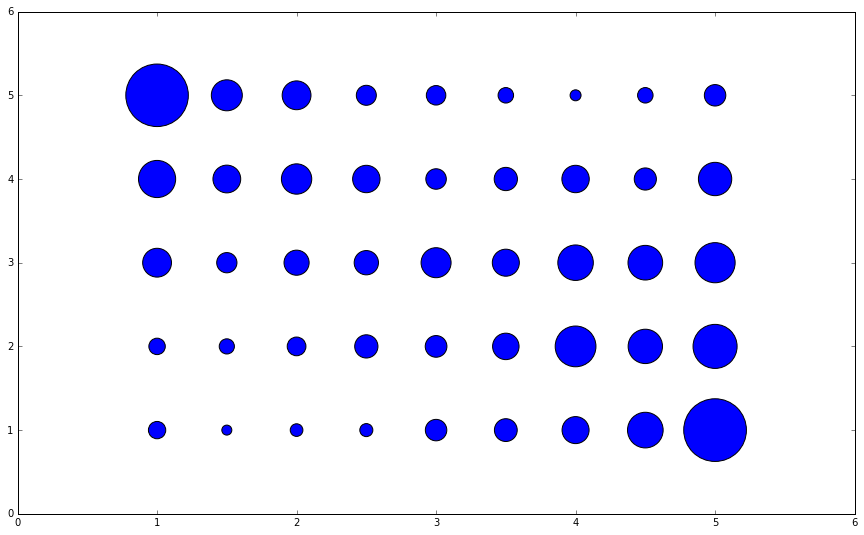

In [10]:
tempDf = ratings[['rOverall', 'rEasy']].copy()
tempDf = tempDf.dropna()
tempDf = tempDf.groupby( [ 'rOverall', 'rEasy'] ).size().to_frame(name = 'count').reset_index()
plt.scatter(tempDf['rOverall'], tempDf['rEasy'], s=tempDf['count']*10)

In [11]:
df = pd.read_csv('ratings.csv')[['rOverall', 'rComments']].dropna().reset_index()
count_vect = CountVectorizer(ngram_range=(1,3))
X_train_counts = count_vect.fit_transform(df.rComments)
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)
X_train_tfidf.shape

(3777, 115384)

In [24]:
tempDf = pd.DataFrame({'WordIndex' : [], 'TF_IDFScores' : [], 'Names' : [], 'rOverall' : []})
for i in df['rOverall'].unique(): 
    indexs = df[df['rOverall'] == i].index.values
    temp_dense = X_train_tfidf[indexs,:].todense()
    MaxFeatureValues = temp_dense.max(axis = 0).tolist()[0]
    phrase_scores = [pair for pair in zip(range(0, len(MaxFeatureValues)), MaxFeatureValues) if pair[1] > 0]
    TopWords = sorted(phrase_scores, key=lambda t: t[1] * -1)[:10]
    ind = [x[0] for x in TopWords]
    featurelist = count_vect.get_feature_names()
    TopWordsNames = [featurelist[j] for j in ind]
    tempDataframe = pd.DataFrame(TopWords, columns=['WordIndex', 'TF_IDFScores'])
    tempDataframe['Names'] = TopWordsNames
    tempDataframe['rOverall'] = i
    tempDf = tempDf.append(tempDataframe)
tempDf

,Names,TF_IDFScores,WordIndex,rOverall
0,easy,1.000000,29363.0,5.0
1,excellent,1.000000,32684.0,5.0
2,good,1.000000,39198.0,5.0
3,helpful,1.000000,45582.0,5.0
4,great class,0.864537,40790.0,5.0
5,interesting class,0.850009,51696.0,5.0
6,she cool,0.810305,83766.0,5.0
7,very good,0.802716,105983.0,5.0
8,awesome professor,0.793600,12567.0,5.0
9,great professor,0.755573,40918.0,5.0


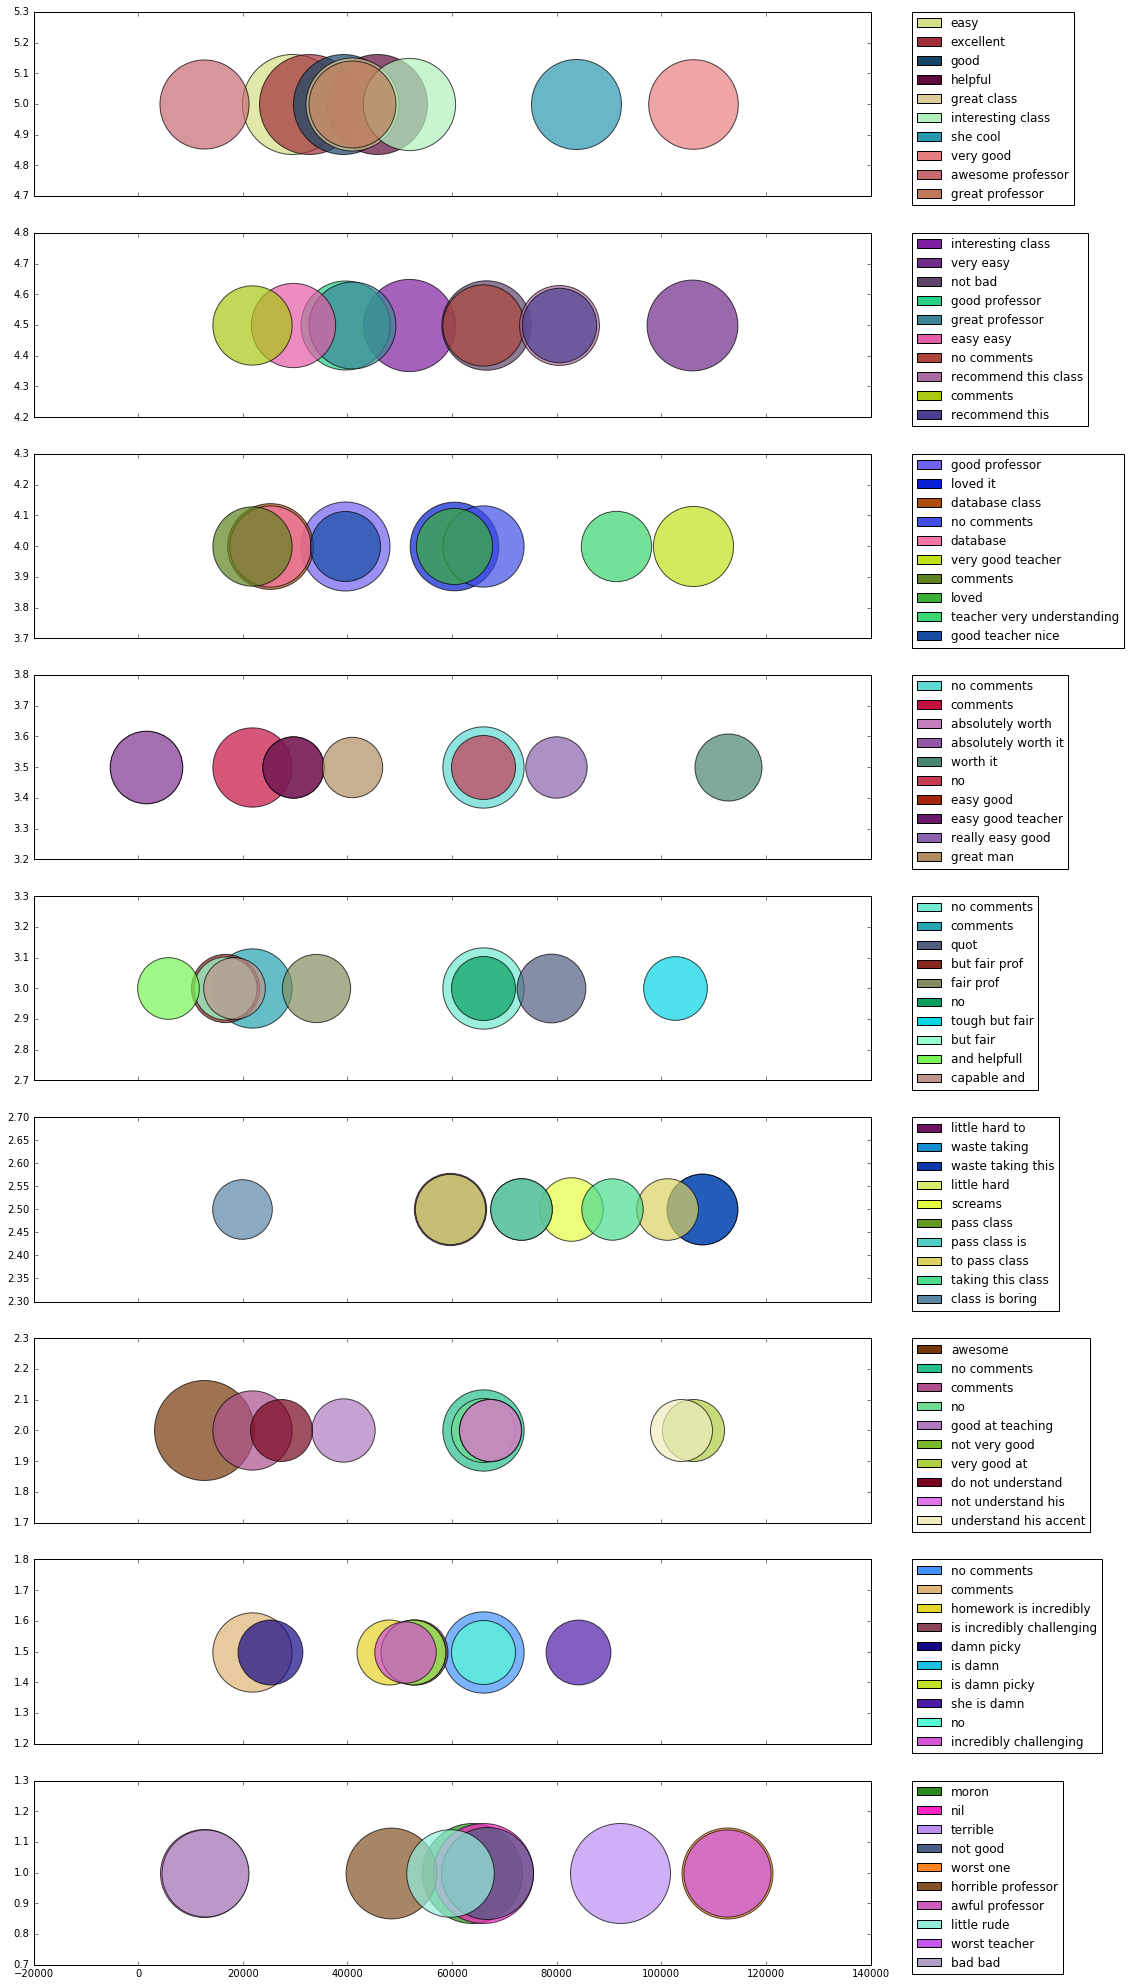

In [65]:
fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 15
fig_size[1] = 35
plt.rcParams["figure.figsize"] = fig_size
fig, ax = plt.subplots(len(tempDf['rOverall'].unique()), sharex = True )
OverallSorted = sorted(tempDf['rOverall'].unique(), key=lambda t: t * -1)
for i in OverallSorted:
    recs = []
    classes = []
    for word in tempDf[tempDf['rOverall'] == i]['WordIndex'].unique():
        color  = np.random.rand(3,1)
        ax[OverallSorted.index(i)].scatter(word, i ,s=tempDf[(tempDf['rOverall'] == i) & (tempDf['WordIndex'] == word)]\
                                               ['TF_IDFScores']*10000, c=color, alpha=0.7)
        recs.append(mpatches.Rectangle((0,0),1,1,fc=color))
        classes.append(tempDf[(tempDf['rOverall'] == i) & (tempDf['WordIndex'] == word)]['Names'].unique()[0])
    ax[OverallSorted.index(i)].legend(recs, classes, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)